# Getting Started: Pixel-Level Segmentation (Task 2)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MTNeuro/MTNeuro/blob/notebook_cleanup/notebooks/task2_getting_started.ipynb)

This **MTNeuro** jupyter notebook takes you through how you can execute `task 2` by loading in the volume cutouts from BossDB (with visualization), training UNet, and evaluating the model with performance metrics.

For more details on the tasks and dataset, please refer to our paper:

    Quesada, J., Sathidevi, L., Liu, R., Ahad, N., Jackson, J.M., Azabou, M., ... & Dyer, E. L. (2022). MTNeuro: A Benchmark for Evaluating Representations of Brain Structure Across Multiple Levels of Abstraction. Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track.

#### Install the required packages

In [ ]:
!pip install 'intern[cloudvolume]' scikit-learn timm pretrainedmodels efficientnet_pytorch segmentation-models-pytorch
!git clone https://github.com/MTNeuro/MTNeuro && cd MTNeuro && pip install .
%cd MTNeuro

#### Import the required packages

In [3]:
import sys
import os
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import numpy as np
import json as json
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp      
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

# BossDB library and MTNeuro dataset loader
from intern import array
from MTNeuro.bossdbdataset import BossDBDataset               
from MTNeuro.trainer import Trainer                    
from MTNeuro.models.unet import UNet   

## Dataset Description

Task 2 (Microstructure Segmentation) is trained with 4 three-dimensional 256 × 256 × 360 cutouts from the somatosensory cortex (CTX), striatum (STR), ventral posterior region of thalamus (VP), and the zona incerta (ZI) from a high-resolution (1.17μm isotropic) 3D microscopy database. These volumetric cutouts contain voxel-level microstructural labels, identifying each voxel as either part of an axon, cell, blood vessel, or background. [[1]](#1)

<img src="https://mtneuro.github.io/images/dataset.png" alt="Dataset" style="width: 70%;">
<img src="https://mtneuro.github.io/images/dataset2.png" alt="Microstructures" style="width: 70%;">

The microstructural annotations are labeled as:
- 0: Background
- 1: Blood Vessels
- 2: Cells
- 3: Axons

The dataset and all corresponding labels are stored publicly in [BossDB](https://bossdb.org/project/prasad2020) and accessed on-demand with [Intern](https://pypi.org/project/intern/), a Python API library.

## Task Description

Task 2 evaluates the ability of baseline models to predict pixel-specific microstructure from the 4 brain regions specified above. In a 3-class setting, the cutouts are segmented into blood vessels, cells, and background + axons. In a 4-class setting, the cutouts are segmented to blood vessels, cells, axons, and background. Since the background and axons of the zona incerta (ZI) are virtually indistinguishable to even trained anatomists, we group axons and background in one class for the 3-class setting, and the 4-class setting is not trained on the zona incerta (ZI). Task 2 can be trained on 2 dimensional cutout images or on 3 dimensional cutout volumes. [[2]](#2)

<img src="https://raw.githubusercontent.com/MTNeuro/MTNeuro/notebook_cleanup/notebooks/images/task2.png" alt="Task 2" style="width: 50%;">

#### Train/Test Split

We use the same train and test split as in ROI-C1 in Task 1: 300 images for train and 50 images for test, with a gap of 10 slices between datasets on the main subvolumes that are densely annotated at the pixel level. [[2]](#2)

|        | Train | Buffer  | Test    |
|:------:|:-----:|:-------:|:-------:|
| Slices | 0-299 | 300-309 | 310-359 |

All slices denoted as "train" are concatenated to form the train dataset, and all slices denoted as "test" are concatenated to form the test dataset.

<br>

<a id="1">[1]</a> Prasad, J. A., Balwani, A. H., Johnson, E. C., Miano, J. D., Sampathkumar, V., De Andrade, V., ... & Dyer, E. L. (2020). A three-dimensional thalamocortical dataset for characterizing brain heterogeneity. Scientific Data, 7(1), 1-7.

<a id="2">[2]</a> Quesada, J., Sathidevi, L., Liu, R., Ahad, N., Jackson, J.M., Azabou, M., ... & Dyer, E. L. (2022). MTNeuro: A Benchmark for Evaluating Representations of Brain Structure Across Multiple Levels of Abstraction. Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track.

#### Specify the Dimensions to Train and the Number of Classes Here:

In [4]:
dimensions = 2      # 2 or 3
class_number = 4    # 3 or 4

## Loading Data

A BossDBDataset object is initialized with the task_config dictionary, the mode of data (`"train"`, `"test"`, `"val"`), and an optional transform function. A BossDBDataset object can be passed into a PyTorch DataLoader to properly split and load in the data into batches for training/testing.

The script for the BossDBDataset can be found [here](https://github.com/MTNeuro/MTNeuro/blob/main/MTNeuro/bossdbdataset.py).



In [5]:
root = "./MTNeuro/"

with open(os.path.join(root, f"taskconfig/task2_{dimensions}D_{class_number}class.json")) as file:
    task_config = json.load(file)
    
# Specify an optional transformation here:

def transform(image, mask):

    # Random rotation
    if random.random() > 0.5:
      angle = random.randint(-30, 30)
      image = TF.rotate(image, angle)
      mask = TF.rotate(mask, angle)

    # Random crop
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256, 256))
    image = TF.crop(image, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)

    # Random horizontal flipping
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    return image, mask


train_data =  BossDBDataset(task_config, mode='train', transform=transform)
val_data = BossDBDataset(task_config, mode='val', transform=transform)
test_data =  BossDBDataset(task_config, mode="test", transform=transform)

## Data Visualization
#### Visualizing the First Slice and Its Groundtruth Annotation

Shape of input: torch.Size([1, 256, 256])
Shape of groundtruth annotations: torch.Size([256, 256])


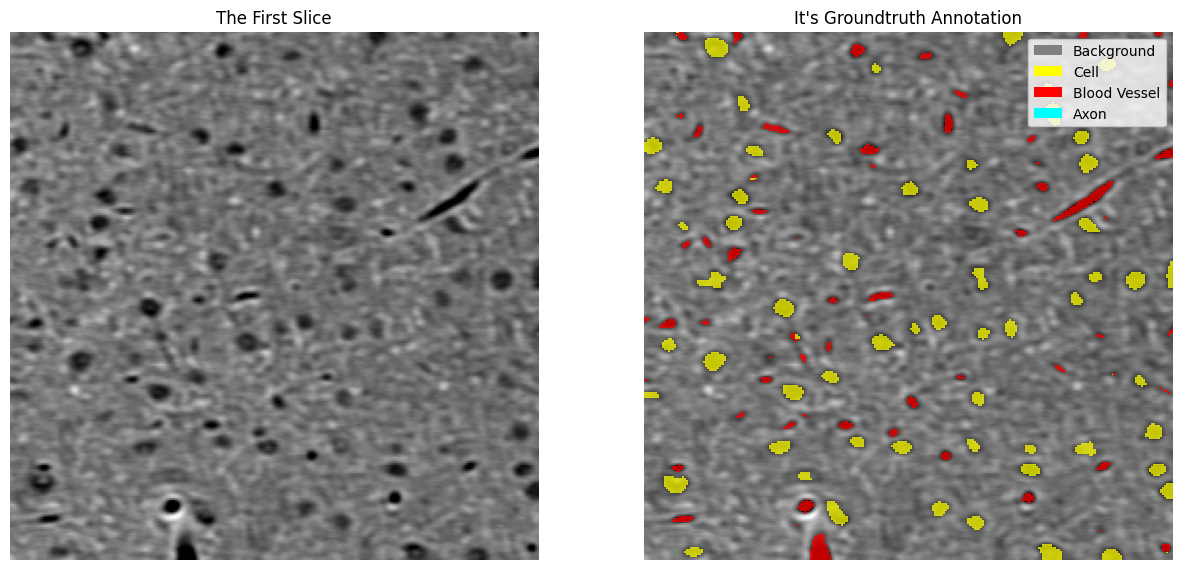

In [6]:
#Access the input and the groundtruth annotations of the first batch
input_data, annotations = train_data[0]
if dimensions == 3:
    input_data, annotations = input_data[0], annotations[0]

#Data Characteristics
print(f'Shape of input: {input_data.shape}')
print(f'Shape of groundtruth annotations: {annotations.shape}')

legend_elements = [Patch(facecolor='grey', label='Background'),
                   Patch(facecolor='yellow', label='Cell'),
                   Patch(facecolor='red', label='Blood Vessel')] if class_number == 3 else [Patch(facecolor='grey', label='Background'),
                   Patch(facecolor='yellow', label='Cell'),
                   Patch(facecolor='red', label='Blood Vessel'),
                   Patch(facecolor='cyan', label='Axon')]

masked_annotations = np.ma.masked_where(annotations == 0, annotations)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(input_data[0], cmap='gray')
ax1.title.set_text("The First Slice")
ax1.axis('off')

cmap = ListedColormap(['grey', 'red', 'yellow', 'cyan'])
ax2.imshow(input_data[0], cmap='gray')
ax2.imshow(masked_annotations.squeeze(), vmin=0, vmax=3, cmap = cmap, alpha = 0.75)
ax2.title.set_text("It's Groundtruth Annotation")
ax2.axis('off')
ax2.legend(handles=legend_elements)

plt.show()

#### A Collage of Random Slices from the Training Data

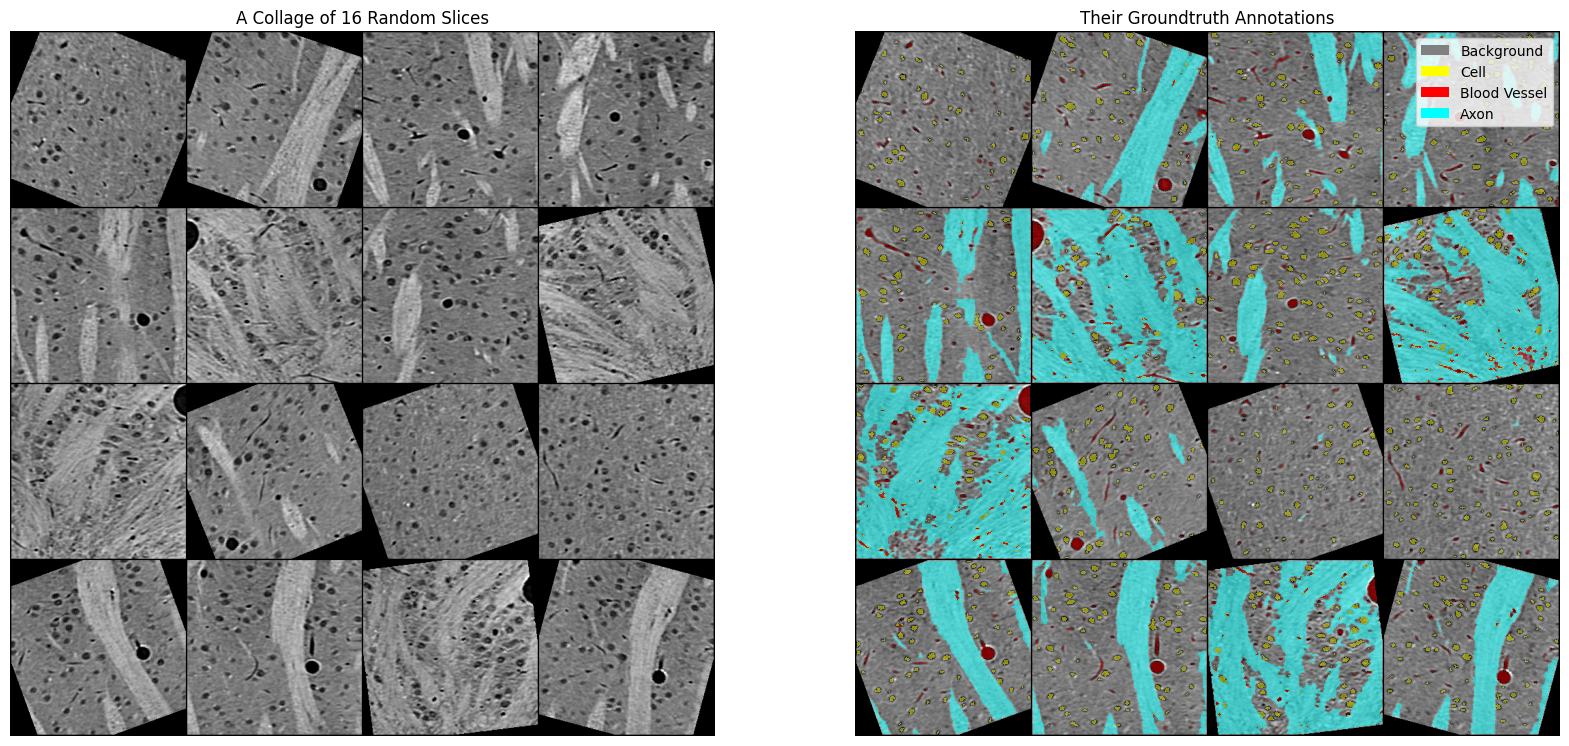

In [7]:
# Reshape data and select a random subset of 16 slices

reshaped_data = []
reshaped_annotations = []
if dimensions == 3:
    for data in train_data:
        reshaped_data = reshaped_data + list(data[0][0])
        reshaped_annotations = reshaped_annotations + list(data[1])
elif dimensions == 2:
    for data in train_data:
        reshaped_data = reshaped_data + [data[0][0]]
        reshaped_annotations = reshaped_annotations + [data[1]]
        
# Zip raw data and annotations together to use random.sample() once
random_samples = random.sample(list(zip(reshaped_data,reshaped_annotations)),16)

# Unzip random samples
random_samples_from_data = [random_data for random_data, random_annotations in random_samples]
random_samples_from_annotations = [random_annotations for random_data, random_annotations in random_samples]
    
grid_img_data = make_grid(torch.stack(random_samples_from_data).unsqueeze(1), nrow=4)
grid_img_annotations = make_grid(torch.stack(random_samples_from_annotations).unsqueeze(1), nrow=4)
masked_annotations = np.ma.masked_where(grid_img_annotations == 0, grid_img_annotations)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(grid_img_data[0], cmap='gray')
ax1.title.set_text("A Collage of 16 Random Slices")
ax1.axis("off")

ax2.imshow(grid_img_data[0], cmap='gray')
ax2.imshow(masked_annotations[0], vmin=0, vmax=3, cmap = cmap, alpha = 0.5)
ax2.title.set_text("Their Groundtruth Annotations")
ax2.axis('off')
ax2.legend(handles=legend_elements)

plt.show()

## Building the Model

This notebook uses UNet as an example baseline model on which to execute Task 2. UNet, a modified fully convolutional neural network that is optimized for biomedical image segmentation, features a U-shaped symmetric contracting and expanding path which can quickly segment all pixels of an input image. [[3]](#3)

See a tutorial and walkthrough of UNet [here](https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial).
See the paper that details UNet's architecture and usage [here](https://arxiv.org/pdf/1505.04597.pdf). 

<img src="https://raw.githubusercontent.com/MTNeuro/MTNeuro/notebook_cleanup/notebooks/images/unet.PNG" alt="UNet" style="width: 80%;">

<a id="3" href="https://arxiv.org/pdf/1505.04597.pdf" target="_blank">[3]</a> Ronneberger, O., Fischer, P., & Brox T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. Medical Image Computing and Computer Assisted Intervention Society.


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the appropriate network configurations JSON files

with open(os.path.join(root, f"networkconfig/UNet_{dimensions}D_{class_number}class.json")) as file:
    network_config = json.load(file)

# Load the model with the configuration specified through the network configurations file.
print('Loading UNet Model')
model = UNet(in_channels = network_config['in_channels'],
             out_channels = network_config['classes'],
             n_blocks = network_config['n_blocks'],
             start_filters = network_config['start_filters'],
             activation = network_config['activation'],
             normalization = network_config['normalization'],
             conv_mode = network_config['conv_mode'],
             dim = network_config['dim']
            ).to(device)

Loading UNet Model


#### Setting the Loss Function and the Optimizer

In [9]:
# Loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Optimizer (Utilizes the network config file)
if network_config["optimizer"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=network_config["learning_rate"])
if network_config["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=network_config["learning_rate"], betas=(network_config["beta1"],network_config["beta2"]))
 

#### Configuring the DataLoader

Documentation on the PyTorch DataLoader can be found [here](https://pytorch.org/docs/stable/data.html).

In [10]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=network_config['batch_size'],
                              shuffle=True)
validation_dataloader = DataLoader(dataset=val_data,
                                   batch_size=network_config['batch_size'],
                                   shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=network_config['batch_size'],
                             shuffle=True)

## Training the Model

The Trainer object assists with training a specified model with data that is feeded in through a DataLoader. Some of its initialization arguments are specified from this notebook, and some are specified through the network configuration JSON file. 

Trainer.run_trainer() initiates the model training process.

The script for Trainer can be found [here](https://github.com/MTNeuro/MTNeuro/blob/main/MTNeuro/trainer.py).

In [ ]:
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_dataloader,
                  validation_DataLoader=validation_dataloader,
                  epochs=network_config["epochs"],
                  notebook=True)

training_losses, validation_losses, lr_rates = trainer.run_trainer()

## Evaluating the Model

In [12]:
def predict(img, model, device):
    """Segments the pixels of a slice using a trained model.
    """
    model.eval()
    x = img.to(device)                     #send input to device
    with torch.inference_mode():
        out = model(x)                     #model forward pass
    out_argmax = torch.argmax(out, dim=1)  #perform softmax on outputs
    return out_argmax

#### Model Prediction

The trained model is tested with the test_dataloader that was initialized when the test dataset was downloaded from BossDB. We keep track of the true positive, false positive, false negative, and true negative scores in tensors for use later. 

In [13]:
# Variables for storing the True Postive, False Positive, False Negative and True Negative scores respectively
tp_tot = torch.empty(0,network_config['classes'])
fp_tot = torch.empty(0,network_config['classes'])
fn_tot = torch.empty(0,network_config['classes'])
tn_tot = torch.empty(0,network_config['classes'])

# Predict on test data
for x, y in test_dataloader:
    target = y.to(device) 
    # Segment the input image with the model
    output = predict(x, model, device)
    # Using segmentation_models_pytorch to calculate the statistics
    tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes = network_config['classes'])
    tp_tot = torch.vstack((tp_tot,tp))
    fp_tot = torch.vstack((fp_tot,fp))
    fn_tot = torch.vstack((fn_tot,fn))
    tn_tot = torch.vstack((tn_tot,tn))

#### Visualizing Model Predictions

One slice, its groundtruth annotation, and the model's predicted annotations are visualized below. Visualizations use the same legend and cmap as the visualizations in above cells.

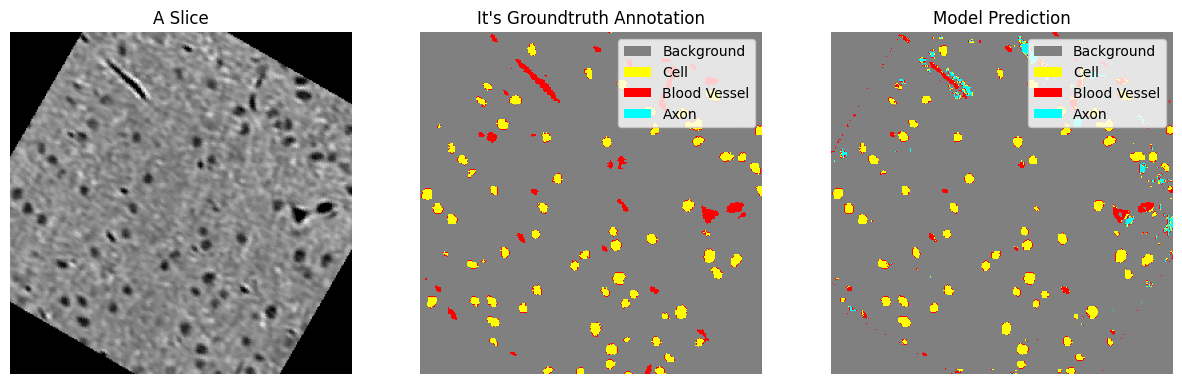

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(x.squeeze()[0], cmap='gray')
ax1.title.set_text("A Slice")
ax1.axis('off')

ax2.imshow(y.squeeze()[0], vmin=0, vmax=3, cmap = cmap)  
ax2.title.set_text("It's Groundtruth Annotation")
ax2.axis('off')
ax2.legend(handles=legend_elements) 

ax3.imshow(output.squeeze()[0], vmin=0, vmax=3, cmap = cmap) 
ax3.title.set_text("Model Prediction")
ax3.axis('off')
ax3.legend(handles=legend_elements) 

plt.show()

#### Calculating Performance Metrics

Metric Calculations:

$$
\begin{aligned}
\text{Accuracy: }&\frac{tp + tn}{fp + tn + fn + tp}\\\\
\text{Balanced Accuracy: }&\frac{\text{Specificity} + \text{Sensitivity}}{2}\\\\
\text{F1-Score: }&\frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}\\\\
\text{IoU: }&\frac{tp}{fp + fn + tp}
\end{aligned}
$$

Where tp = true positive, tn = true negative, fp = false positive, and fn = false negative.

In [15]:
# Accuracy
acc = (tp_tot.mean(dim=0)+tn_tot.mean(dim=0))/(fp_tot.mean(dim=0)+tn_tot.mean(dim=0)+fn_tot.mean(dim=0)+tp_tot.mean(dim=0)) 
print('New Accuracy per Class:', np.array(acc.cpu()))

# Balanced Accuracy
spec =  (tn_tot[:,1:].mean())/(fp_tot[:,1:].mean()+tn_tot[:,1:].mean())
sens =  (tp_tot[:,1:].mean())/(fn_tot[:,1:].mean()+tp_tot[:,1:].mean())
balacc = (spec + sens)/2
print(f'New Balanced Accuracy (No Background): {balacc}')

# F1-score
prec = tp_tot.mean(dim=0)/(fp_tot.mean(dim=0)+tp_tot.mean(dim=0))
reca = tp_tot.mean(dim=0)/(fn_tot.mean(dim=0)+tp_tot.mean(dim=0))
f1 = (2*reca*prec)/(reca+prec)
print(f'New F1-Score: {np.array(f1.cpu())}\nAvg. F1-Score: {f1.mean()}')

# IoU
iou = (tp_tot.mean(0))/(fp_tot.mean(0)+fn_tot.mean(0)+tp_tot.mean(0))
print(f'New IoU: {np.array(iou.cpu())}\nAvg. IoU-Score: {iou.mean()}')

New Accuracy per Class: [0.91873085 0.97550786 0.97447264 0.9355955 ]
New Balanced Accuracy (No Background): 0.919655442237854
New F1-Score: [0.9374128  0.54552007 0.74080855 0.88271487]
Avg. F1-Score: 0.7766140699386597
New IoU: [0.8821984  0.37506196 0.5883208  0.79005337]
Avg. IoU-Score: 0.6589086055755615
